In [2]:
import pandas as pd
from metrics import indicators, forecast
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt

In [3]:
stock_data = pd.read_csv("stock-prices/ANGELONE.NS.csv")
stock_data

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-09-17 09:15:00+05:30,2582.600098,2585.949951,2558.550049,2574.750000,0,0.0,0.0
1,2024-09-17 09:16:00+05:30,2574.750000,2574.750000,2561.250000,2567.350098,15299,0.0,0.0
2,2024-09-17 09:17:00+05:30,2565.500000,2568.199951,2561.449951,2564.000000,13237,0.0,0.0
3,2024-09-17 09:18:00+05:30,2564.600098,2566.350098,2560.000000,2566.199951,4504,0.0,0.0
4,2024-09-17 09:19:00+05:30,2567.850098,2575.000000,2563.350098,2568.750000,10241,0.0,0.0
...,...,...,...,...,...,...,...,...
1867,2024-09-23 15:25:00+05:30,2620.100098,2621.000000,2620.100098,2620.100098,1206,0.0,0.0
1868,2024-09-23 15:26:00+05:30,2620.899902,2621.000000,2620.000000,2621.000000,3578,0.0,0.0
1869,2024-09-23 15:27:00+05:30,2620.000000,2620.000000,2617.699951,2619.050049,1835,0.0,0.0
1870,2024-09-23 15:28:00+05:30,2619.000000,2619.100098,2615.000000,2616.000000,2623,0.0,0.0


In [4]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Base Dense Model

### Data preprocessing

In [4]:
data = pd.concat([stock_data, forecast.precise_forecast(stock_data)], axis=1)
data.drop("Datetime", axis=1, inplace=True)
data.dropna(inplace=True)
columns = data.columns

# scaling data
data = pd.DataFrame(StandardScaler().fit_transform(data))
data.columns = columns

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,precise_forecast
0,-0.118501,-0.085952,-0.670882,-0.314421,-0.668957,0.0,0.0,0.153873
1,-0.314817,-0.364095,-0.603059,-0.499519,2.468595,0.0,0.0,0.120154
2,-0.546141,-0.526761,-0.598036,-0.583317,2.045716,0.0,0.0,0.098919
3,-0.568646,-0.572701,-0.634459,-0.528288,0.254733,0.0,0.0,-0.025978
4,-0.487370,-0.357887,-0.550304,-0.464502,1.431290,0.0,0.0,-0.088427
...,...,...,...,...,...,...,...,...
1857,0.690506,0.634243,0.680582,0.654857,-0.294887,0.0,0.0,0.813334
1858,0.666750,0.635486,0.713233,0.658606,0.030373,0.0,0.0,0.835813
1859,0.620482,0.614374,0.673044,0.641098,-0.224954,0.0,0.0,0.787104
1860,0.670499,0.614374,0.624061,0.587321,0.142553,0.0,0.0,0.710916


In [5]:
X = data[["Open", "High", "Low", "Close"]]
y = data["precise_forecast"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1489, 4), (373, 4), (1489,), (373,))

### Model fitting

In [6]:
model1 = Sequential([
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model1.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae", "mse"]
)

history1 = model1.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20


2024-10-05 11:05:22.916629: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-05 11:05:22.916692: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-05 11:05:22.916699: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-05 11:05:22.916732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-05 11:05:22.916747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 1/38 [..............................] - ETA: 15s - loss: 1.2865 - mae: 1.0032 - mse: 1.2865

2024-10-05 11:05:23.328690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 1s 13ms/step - loss: 0.2405 - mae: 0.3322 - mse: 0.2405 - val_loss: 0.1138 - val_mae: 0.2180 - val_mse: 0.1138
Epoch 2/20
12/38 [========>.....................] - ETA: 0s - loss: 0.0975 - mae: 0.2194 - mse: 0.0975

2024-10-05 11:05:23.891170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 0s 8ms/step - loss: 0.0902 - mae: 0.2082 - mse: 0.0902 - val_loss: 0.0983 - val_mae: 0.1997 - val_mse: 0.0983
Epoch 3/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0873 - mae: 0.2033 - mse: 0.0873 - val_loss: 0.0963 - val_mae: 0.1981 - val_mse: 0.0963
Epoch 4/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0877 - mae: 0.2042 - mse: 0.0877 - val_loss: 0.1065 - val_mae: 0.2084 - val_mse: 0.1065
Epoch 5/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0883 - mae: 0.2042 - mse: 0.0883 - val_loss: 0.0973 - val_mae: 0.1982 - val_mse: 0.0973
Epoch 6/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0878 - mae: 0.2029 - mse: 0.0878 - val_loss: 0.0957 - val_mae: 0.1975 - val_mse: 0.0957
Epoch 7/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0871 - mae: 0.2023 - mse: 0.0871 - val_loss: 0.0960 - val_mae: 0.1972 - val_mse: 0.0960
Epoch 8/20
38/38 [=====================

### Model evaluation and visualisation

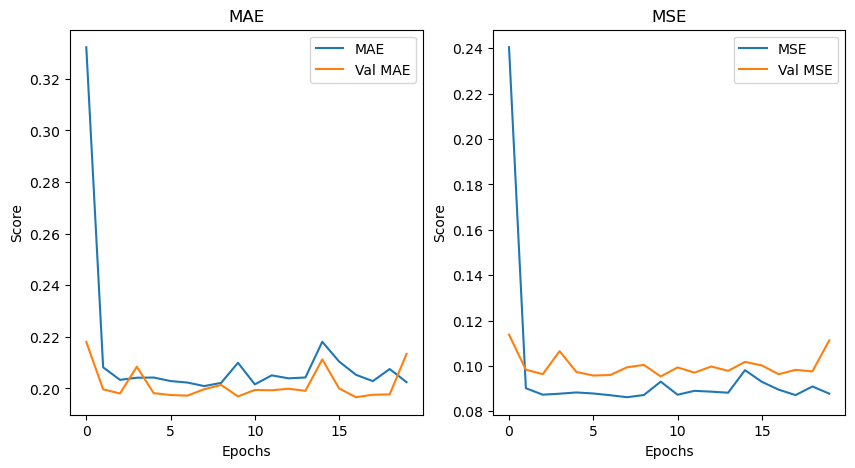

In [7]:
mae = history1.history["mae"]
val_mae = history1.history["val_mae"]
mse = history1.history["mse"]
val_mse = history1.history["val_mse"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mae)
plt.plot(val_mae)
plt.title("MAE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MAE", "Val MAE"])

plt.subplot(1, 2, 2)
plt.plot(mse)
plt.plot(val_mse)
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MSE", "Val MSE"])

12/12 [==============================] - 0s 3ms/step


2024-10-05 11:05:29.578675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


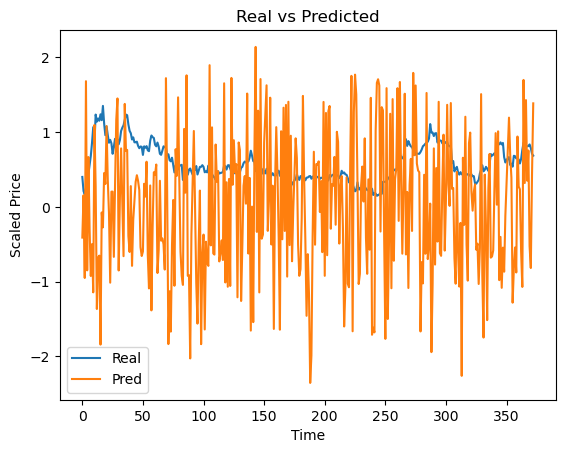

In [8]:
real = y[X_train.shape[0]:]
real.index = range(len(real))
pred = model1.predict(X_test)

plt.plot(real)
plt.plot(pred)
plt.title("Real vs Predicted")
plt.xlabel("Time")
plt.ylabel("Scaled Price")
plt.legend(["Real", "Pred"])

# Base LSTM Model

### Data preprocessing

In [5]:
time_steps = 10

data = pd.concat([stock_data, forecast.precise_forecast(stock_data, span=time_steps)], axis=1)
data.drop("Datetime", axis=1, inplace=True)
data.dropna(inplace=True)
columns = data.columns

# scaling data
data = pd.DataFrame(StandardScaler().fit_transform(data))
data.columns = columns

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,precise_forecast_10
0,-0.118501,-0.085952,-0.670882,-0.314421,-0.668957,0.0,0.0,0.153873
1,-0.314817,-0.364095,-0.603059,-0.499519,2.468595,0.0,0.0,0.120154
2,-0.546141,-0.526761,-0.598036,-0.583317,2.045716,0.0,0.0,0.098919
3,-0.568646,-0.572701,-0.634459,-0.528288,0.254733,0.0,0.0,-0.025978
4,-0.487370,-0.357887,-0.550304,-0.464502,1.431290,0.0,0.0,-0.088427
...,...,...,...,...,...,...,...,...
1857,0.690506,0.634243,0.680582,0.654857,-0.294887,0.0,0.0,0.813334
1858,0.666750,0.635486,0.713233,0.658606,0.030373,0.0,0.0,0.835813
1859,0.620482,0.614374,0.673044,0.641098,-0.224954,0.0,0.0,0.787104
1860,0.670499,0.614374,0.624061,0.587321,0.142553,0.0,0.0,0.710916


In [7]:
X = data[["Open", "High", "Low", "Close"]]
y = data["precise_forecast_10"]
X_seq, y_seq = create_sequences(X, y, time_steps=time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1481, 10, 4), (371, 10, 4), (1481,), (371,))

In [10]:
X_seq

array([[[-0.11850109, -0.08595226, -0.67088217, -0.31442056],
        [-0.31481686, -0.36409545, -0.60305907, -0.49951882],
        [-0.54614149, -0.52676146, -0.59803627, -0.58331685],
        ...,
        [ 0.09156424,  0.25924844,  0.08774431,  0.06828888],
        [ 0.12282433,  0.08292233,  0.14175013,  0.1258214 ],
        [ 0.23161186,  0.23192826,  0.07266979,  0.05078058]],

       [[-0.31481686, -0.36409545, -0.60305907, -0.49951882],
        [-0.54614149, -0.52676146, -0.59803627, -0.58331685],
        [-0.56864631, -0.57270132, -0.63445922, -0.52828814],
        ...,
        [ 0.12282433,  0.08292233,  0.14175013,  0.1258214 ],
        [ 0.23161186,  0.23192826,  0.07266979,  0.05078058],
        [ 0.02654082,  0.23689391,  0.07894982,  0.15958611]],

       [[-0.54614149, -0.52676146, -0.59803627, -0.58331685],
        [-0.56864631, -0.57270132, -0.63445922, -0.52828814],
        [-0.48737009, -0.35788687, -0.55030436, -0.46450221],
        ...,
        [ 0.23161186,  0.23

### Model fitting

In [11]:
model2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 4)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model2.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae", "mse"]
)

history2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20


2024-10-05 11:05:30.932312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:31.147855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:31.239741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:31.364296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:31.515307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/37 [===========================>..] - ETA: 0s - loss: 0.3475 - mae: 0.4128 - mse: 0.3475

2024-10-05 11:05:32.561742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:32.656208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:32.723064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 3s 35ms/step - loss: 0.3334 - mae: 0.4009 - mse: 0.3334 - val_loss: 0.1636 - val_mae: 0.2699 - val_mse: 0.1636
Epoch 2/20
37/37 [==============================] - 1s 15ms/step - loss: 0.1167 - mae: 0.2430 - mse: 0.1167 - val_loss: 0.1523 - val_mae: 0.2619 - val_mse: 0.1523
Epoch 3/20
37/37 [==============================] - 1s 14ms/step - loss: 0.1057 - mae: 0.2290 - mse: 0.1057 - val_loss: 0.1494 - val_mae: 0.2570 - val_mse: 0.1494
Epoch 4/20
37/37 [==============================] - 1s 14ms/step - loss: 0.1026 - mae: 0.2234 - mse: 0.1026 - val_loss: 0.1448 - val_mae: 0.2521 - val_mse: 0.1448
Epoch 5/20
37/37 [==============================] - 0s 12ms/step - loss: 0.1034 - mae: 0.2248 - mse: 0.1034 - val_loss: 0.1433 - val_mae: 0.2513 - val_mse: 0.1433
Epoch 6/20
37/37 [==============================] - 1s 14ms/step - loss: 0.1008 - mae: 0.2211 - mse: 0.1008 - val_loss: 0.1420 - val_mae: 0.2497 - val_mse: 0.1420
Epoch 7/20
37/37 [===============

### Model evaluation and visualisation

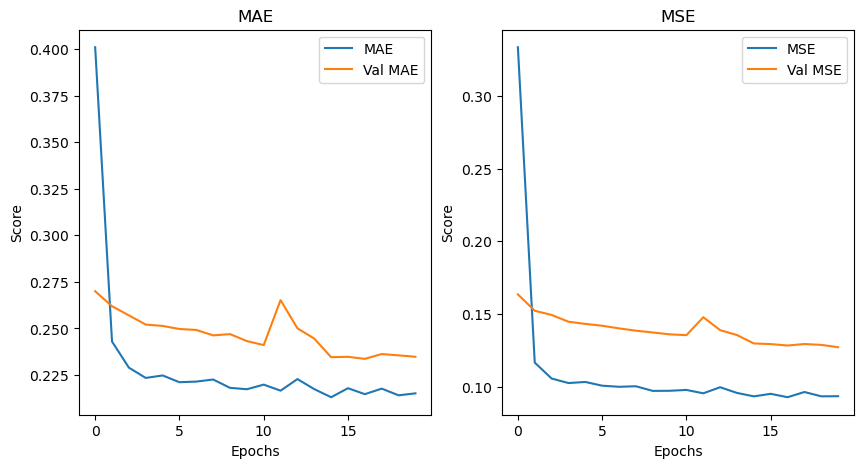

In [12]:
mae = history2.history["mae"]
val_mae = history2.history["val_mae"]
mse = history2.history["mse"]
val_mse = history2.history["val_mse"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mae)
plt.plot(val_mae)
plt.title("MAE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MAE", "Val MAE"])

plt.subplot(1, 2, 2)
plt.plot(mse)
plt.plot(val_mse)
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MSE", "Val MSE"])

 1/12 [=>............................] - ETA: 3s

2024-10-05 11:05:42.467527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:42.535135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:42.593856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 6ms/step


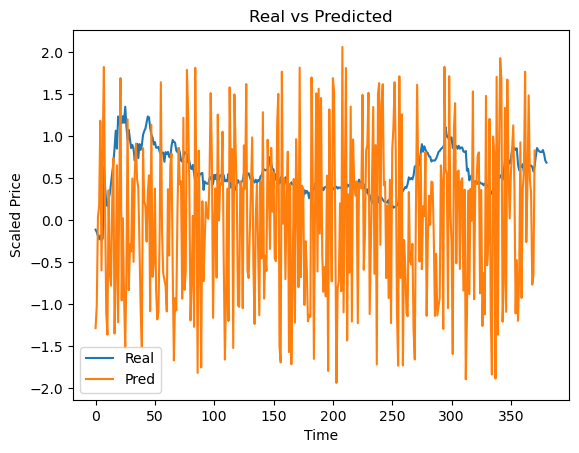

In [13]:
real = y[X_train.shape[0]:]
real.index = range(len(real))
pred = model2.predict(X_test)

plt.plot(real)
plt.plot(pred)
plt.title("Real vs Predicted")
plt.xlabel("Time")
plt.ylabel("Scaled Price")
plt.legend(["Real", "Pred"])

##### The base LSTM model does not work very well. Predictions are mostly just noise.

# Indicator Dense Model

### Data preprocessing

In [14]:
engulfing = indicators.engulfing(stock_data)
marubozo = indicators.marubozo(stock_data)
doji = indicators.doji(stock_data)
hammer = indicators.hammer(stock_data)
inverted_hammer = indicators.inverted_hammer(stock_data)
macd = indicators.macd(stock_data)
bollinger_bands = indicators.bollinger_bands(stock_data)
rsi = indicators.rsi(stock_data)

data = pd.concat([stock_data, engulfing, marubozo, doji, hammer, inverted_hammer, macd, bollinger_bands, rsi, forecast.precise_forecast(stock_data)], axis=1)
data.drop("Datetime", axis=1, inplace=True)
data.dropna(inplace=True)
data.index = range(len(data))

enc = OneHotEncoder()
engulfing = enc.fit_transform(np.reshape(data["engulfing"], (-1, 1)))
engulfing_enc = pd.DataFrame(engulfing.toarray())
engulfing_enc.columns = enc.get_feature_names_out(["engulfing"])

enc = OneHotEncoder()
marubozo = enc.fit_transform(np.reshape(data["marubozo"], (-1, 1)))
marubozo_enc = pd.DataFrame(marubozo.toarray())
marubozo_enc.columns = enc.get_feature_names_out(["marubozo"])

data = pd.concat([data, engulfing_enc, marubozo_enc], axis=1)
data.drop(["engulfing", "marubozo"], axis=1, inplace=True)
columns = data.columns

# scaling data
data = pd.DataFrame(StandardScaler().fit_transform(data))
data.columns = columns

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,doji,hammer,inverted_hammer,...,bollinger_upper_band,bollinger_lower_band,rsi,precise_forecast,engulfing_bearish,engulfing_bullish,engulfing_none,marubozo_bearish,marubozo_bullish,marubozo_none
0,-0.571540,-0.531555,-0.523099,-0.550290,-0.121646,0.0,0.0,-0.165267,-0.270894,3.630003,...,2.343227,0.166029,-0.585802,-0.663738,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
1,-0.532955,-0.458637,-0.499338,-0.433262,-0.041477,0.0,0.0,-0.165267,-0.270894,-0.275482,...,1.900992,-0.200985,-1.040979,-0.617717,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
2,-0.419692,-0.432681,-0.370522,-0.384708,-0.425082,0.0,0.0,-0.165267,-0.270894,-0.275482,...,1.701582,-0.294157,-0.873320,-0.589113,-0.431244,-0.403455,0.649668,-0.245793,4.576077,-2.958263
3,-0.384845,-0.432681,-0.503088,-0.490533,0.287505,0.0,0.0,-0.165267,-0.270894,-0.275482,...,2.078681,0.049707,-1.171838,-0.463492,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
4,-0.526732,-0.534023,-0.478076,-0.507961,-0.397459,0.0,0.0,-0.165267,-0.270894,-0.275482,...,2.139927,0.108536,-1.099228,-0.549310,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,0.685540,0.630207,0.674990,0.649879,-0.286344,0.0,0.0,-0.165267,-0.270894,-0.275482,...,-0.108257,0.371578,-0.727606,0.806383,2.318871,-0.403455,-1.539249,-0.245793,-0.218528,0.338036
1839,0.661893,0.631444,0.707501,0.653612,0.043053,0.0,0.0,-0.165267,-0.270894,3.630003,...,-0.127255,0.351893,-0.848703,0.828768,2.318871,-0.403455,-1.539249,-0.245793,-0.218528,0.338036
1840,0.615839,0.610431,0.667486,0.636183,-0.215522,0.0,0.0,-0.165267,-0.270894,-0.275482,...,-0.072910,0.384905,-0.817665,0.780263,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
1841,0.665625,0.610431,0.618713,0.582651,0.156660,0.0,0.0,-0.165267,-0.270894,-0.275482,...,0.129762,0.505030,-1.085815,0.704393,2.318871,-0.403455,-1.539249,-0.245793,-0.218528,0.338036


In [15]:
X = data.drop("precise_forecast", axis=1)
y = data["precise_forecast"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1474, 23), (369, 23), (1474,), (369,))

### Model fitting

In [16]:
model3 = Sequential([
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model3.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae", "mse"]
)

history3 = model3.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
12/37 [========>.....................] - ETA: 0s - loss: 3.3694 - mae: 1.4504 - mse: 3.3694

2024-10-05 11:05:43.166690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 11ms/step - loss: 1.3379 - mae: 0.7666 - mse: 1.3379 - val_loss: 0.1338 - val_mae: 0.2641 - val_mse: 0.1338
Epoch 2/20
12/37 [========>.....................] - ETA: 0s - loss: 0.1088 - mae: 0.2553 - mse: 0.1088

2024-10-05 11:05:43.589631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 6ms/step - loss: 0.1121 - mae: 0.2348 - mse: 0.1121 - val_loss: 0.0893 - val_mae: 0.2040 - val_mse: 0.0893
Epoch 3/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0967 - mae: 0.2103 - mse: 0.0967 - val_loss: 0.0871 - val_mae: 0.2026 - val_mse: 0.0871
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0956 - mae: 0.2072 - mse: 0.0956 - val_loss: 0.0854 - val_mae: 0.2019 - val_mse: 0.0854
Epoch 5/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0965 - mae: 0.2100 - mse: 0.0965 - val_loss: 0.0869 - val_mae: 0.2025 - val_mse: 0.0869
Epoch 6/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0962 - mae: 0.2085 - mse: 0.0962 - val_loss: 0.0895 - val_mae: 0.2031 - val_mse: 0.0895
Epoch 7/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0973 - mae: 0.2101 - mse: 0.0973 - val_loss: 0.0904 - val_mae: 0.2065 - val_mse: 0.0904
Epoch 8/20
37/37 [=====================

### Model evaluation and visualisation

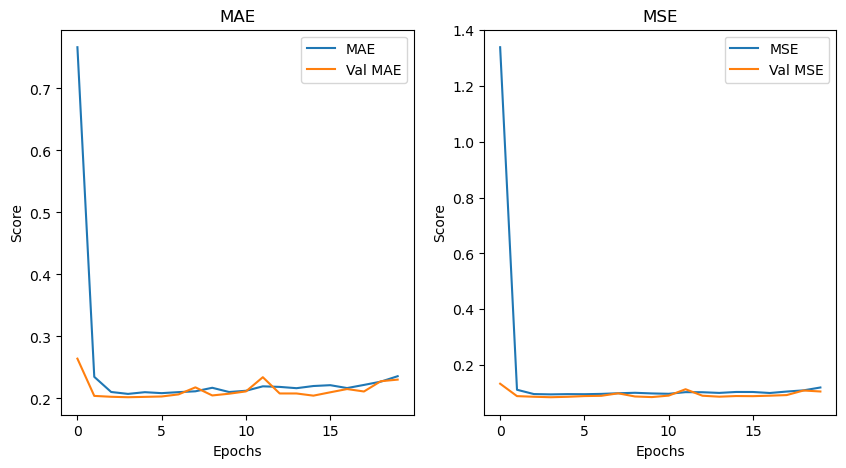

In [17]:
mae = history3.history["mae"]
val_mae = history3.history["val_mae"]
mse = history3.history["mse"]
val_mse = history3.history["val_mse"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mae)
plt.plot(val_mae)
plt.title("MAE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MAE", "Val MAE"])

plt.subplot(1, 2, 2)
plt.plot(mse)
plt.plot(val_mse)
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MSE", "Val MSE"])

12/12 [==============================] - 0s 3ms/step


2024-10-05 11:05:48.363611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


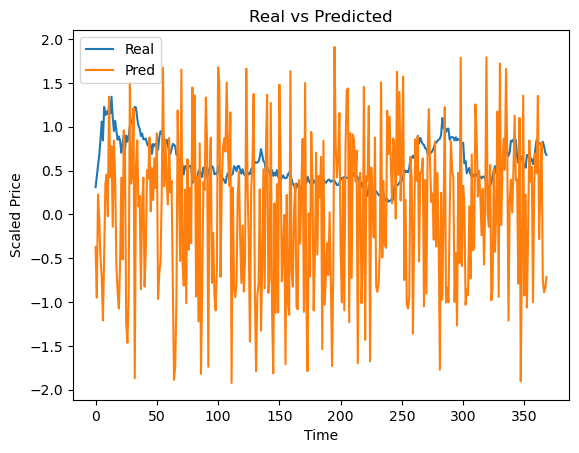

In [18]:
real = y[X_train.shape[0]:]
real.index = range(len(real))
pred = model3.predict(X_test)

plt.plot(real)
plt.plot(pred)
plt.title("Real vs Predicted")
plt.xlabel("Time")
plt.ylabel("Scaled Price")
plt.legend(["Real", "Pred"])

# Indicator LSTM Model

### Data preprocessing

In [19]:
time_steps = 10

engulfing = indicators.engulfing(stock_data)
marubozo = indicators.marubozo(stock_data)
doji = indicators.doji(stock_data)
hammer = indicators.hammer(stock_data)
inverted_hammer = indicators.inverted_hammer(stock_data)
macd = indicators.macd(stock_data)
bollinger_bands = indicators.bollinger_bands(stock_data)
rsi = indicators.rsi(stock_data)

data = pd.concat([stock_data, engulfing, marubozo, doji, hammer, inverted_hammer, macd, bollinger_bands, rsi, forecast.precise_forecast(stock_data, span=time_steps)], axis=1)
data.drop("Datetime", axis=1, inplace=True)
data.dropna(inplace=True)
data.index = range(len(data))

enc = OneHotEncoder()
engulfing = enc.fit_transform(np.reshape(data["engulfing"], (-1, 1)))
engulfing_enc = pd.DataFrame(engulfing.toarray())
engulfing_enc.columns = enc.get_feature_names_out(["engulfing"])

enc = OneHotEncoder()
marubozo = enc.fit_transform(np.reshape(data["marubozo"], (-1, 1)))
marubozo_enc = pd.DataFrame(marubozo.toarray())
marubozo_enc.columns = enc.get_feature_names_out(["marubozo"])

data = pd.concat([data, engulfing_enc, marubozo_enc], axis=1)
data.drop(["engulfing", "marubozo"], axis=1, inplace=True)
columns = data.columns

# scaling data
data = pd.DataFrame(StandardScaler().fit_transform(data))
data.columns = columns

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,doji,hammer,inverted_hammer,...,bollinger_upper_band,bollinger_lower_band,rsi,precise_forecast,engulfing_bearish,engulfing_bullish,engulfing_none,marubozo_bearish,marubozo_bullish,marubozo_none
0,-0.571540,-0.531555,-0.523099,-0.550290,-0.121646,0.0,0.0,-0.165267,-0.270894,3.630003,...,2.343227,0.166029,-0.585802,-0.663738,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
1,-0.532955,-0.458637,-0.499338,-0.433262,-0.041477,0.0,0.0,-0.165267,-0.270894,-0.275482,...,1.900992,-0.200985,-1.040979,-0.617717,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
2,-0.419692,-0.432681,-0.370522,-0.384708,-0.425082,0.0,0.0,-0.165267,-0.270894,-0.275482,...,1.701582,-0.294157,-0.873320,-0.589113,-0.431244,-0.403455,0.649668,-0.245793,4.576077,-2.958263
3,-0.384845,-0.432681,-0.503088,-0.490533,0.287505,0.0,0.0,-0.165267,-0.270894,-0.275482,...,2.078681,0.049707,-1.171838,-0.463492,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
4,-0.526732,-0.534023,-0.478076,-0.507961,-0.397459,0.0,0.0,-0.165267,-0.270894,-0.275482,...,2.139927,0.108536,-1.099228,-0.549310,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,0.685540,0.630207,0.674990,0.649879,-0.286344,0.0,0.0,-0.165267,-0.270894,-0.275482,...,-0.108257,0.371578,-0.727606,0.806383,2.318871,-0.403455,-1.539249,-0.245793,-0.218528,0.338036
1839,0.661893,0.631444,0.707501,0.653612,0.043053,0.0,0.0,-0.165267,-0.270894,3.630003,...,-0.127255,0.351893,-0.848703,0.828768,2.318871,-0.403455,-1.539249,-0.245793,-0.218528,0.338036
1840,0.615839,0.610431,0.667486,0.636183,-0.215522,0.0,0.0,-0.165267,-0.270894,-0.275482,...,-0.072910,0.384905,-0.817665,0.780263,-0.431244,-0.403455,0.649668,-0.245793,-0.218528,0.338036
1841,0.665625,0.610431,0.618713,0.582651,0.156660,0.0,0.0,-0.165267,-0.270894,-0.275482,...,0.129762,0.505030,-1.085815,0.704393,2.318871,-0.403455,-1.539249,-0.245793,-0.218528,0.338036


In [20]:
X = data.drop("precise_forecast", axis=1)
y = data["precise_forecast"]
X_seq, y_seq = create_sequences(X, y, time_steps=time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1466, 10, 23), (367, 10, 23), (1466,), (367,))

### Model fitting

In [21]:
model4 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 23)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model4.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae", "mse"]
)

history4 = model4.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20


2024-10-05 11:05:49.828317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:50.045613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:50.117466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:50.244985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/37 [===>..........................] - ETA: 0s - loss: 0.8736 - mae: 0.7491 - mse: 0.8736 

2024-10-05 11:05:50.367756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 0.3248 - mae: 0.4048 - mse: 0.3248

2024-10-05 11:05:51.353259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:51.434970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:05:51.496272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 3s 33ms/step - loss: 0.3248 - mae: 0.4048 - mse: 0.3248 - val_loss: 0.1154 - val_mae: 0.2370 - val_mse: 0.1154
Epoch 2/20
37/37 [==============================] - 1s 14ms/step - loss: 0.1075 - mae: 0.2267 - mse: 0.1075 - val_loss: 0.0988 - val_mae: 0.2245 - val_mse: 0.0988
Epoch 3/20
37/37 [==============================] - 1s 14ms/step - loss: 0.0927 - mae: 0.2139 - mse: 0.0927 - val_loss: 0.0891 - val_mae: 0.2033 - val_mse: 0.0891
Epoch 4/20
37/37 [==============================] - 1s 14ms/step - loss: 0.0862 - mae: 0.2016 - mse: 0.0862 - val_loss: 0.0817 - val_mae: 0.1950 - val_mse: 0.0817
Epoch 5/20
37/37 [==============================] - 1s 14ms/step - loss: 0.0803 - mae: 0.1953 - mse: 0.0803 - val_loss: 0.0767 - val_mae: 0.1878 - val_mse: 0.0767
Epoch 6/20
37/37 [==============================] - 1s 14ms/step - loss: 0.0753 - mae: 0.1872 - mse: 0.0753 - val_loss: 0.0775 - val_mae: 0.1884 - val_mse: 0.0775
Epoch 7/20
37/37 [===============

### Model evaluation and visualisation

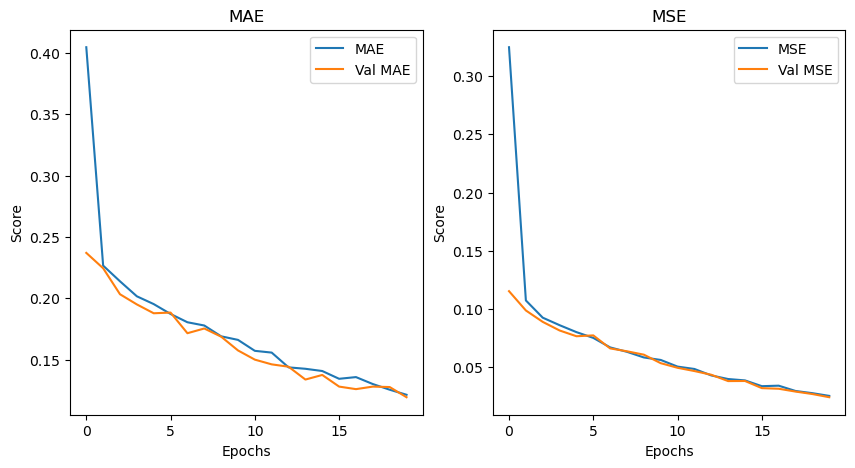

In [22]:
mae = history4.history["mae"]
val_mae = history4.history["val_mae"]
mse = history4.history["mse"]
val_mse = history4.history["val_mse"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mae)
plt.plot(val_mae)
plt.title("MAE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MAE", "Val MAE"])

plt.subplot(1, 2, 2)
plt.plot(mse)
plt.plot(val_mse)
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(["MSE", "Val MSE"])

 1/12 [=>............................] - ETA: 4s

2024-10-05 11:06:02.840182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:06:02.910373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-05 11:06:02.970263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 6ms/step


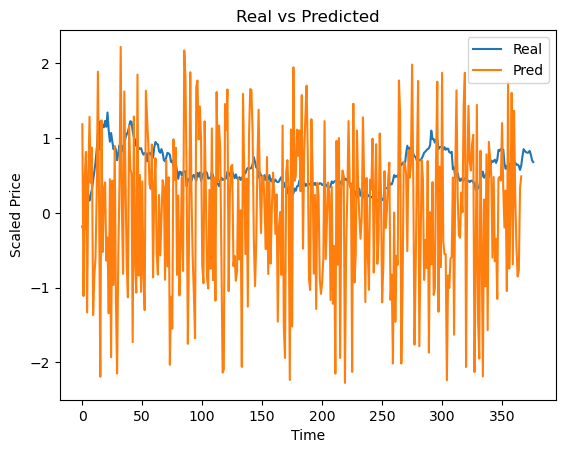

In [23]:
real = y[X_train.shape[0]:]
real.index = range(len(real))
pred = model4.predict(X_test)

plt.plot(real)
plt.plot(pred)
plt.title("Real vs Predicted")
plt.xlabel("Time")
plt.ylabel("Scaled Price")
plt.legend(["Real", "Pred"])